# Custom Models and Training with TensorFlow

### Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Using Tensorflow like Numpy

In [2]:
t = tf.constant([[1, 2, 3], [4, 5, 6]])
t, t.shape, t.dtype

(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
 array([[1, 2, 3],
        [4, 5, 6]])>,
 TensorShape([2, 3]),
 tf.int32)

In [3]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[14, 32],
       [32, 77]])>

In [4]:
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

### Tensors and NumPy

In [5]:
a = np.array([2, 4, 5])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([2, 4, 5])>

In [6]:
t.numpy()

array([[1, 2, 3],
       [4, 5, 6]])

In [7]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 16, 25])>

In [8]:
np.square(t).T

array([[ 1, 16],
       [ 4, 25],
       [ 9, 36]])

### Type Conversions

In [10]:
# Throws an error.
try:
    tf.constant(2.) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]


In [11]:
# Throws an error.
try:
    tf.constant(2.) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]


In [12]:
# Use casting.
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### Variables

In [13]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [14]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [15]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [16]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [17]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [20]:
# Direct assignment throws an error.
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


### Customizing Models and Training Algorithms

In [21]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [22]:
# Create a customized threshold.
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        def huber_fn(y_true, y_pred):
            error = y_true - y_pred
            is_small_error = tf.abs(error) < threshold
            squared_loss = tf.square(error) / 2
            linear_loss = threshold * tf.abs(error) - threshold ** 2 / 2
            return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

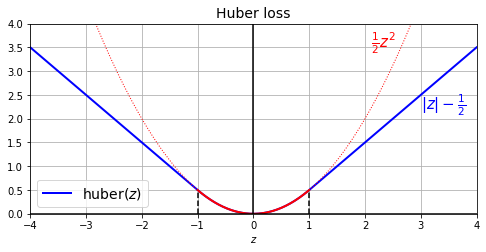

In [23]:
# Huber loss
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [24]:
# Test loss function.
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_shape = X_train.shape[1:]

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [25]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [26]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6255 - mae: 0.9906 - val_loss: 0.3128 - val_mae: 0.6248
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2657 - mae: 0.5759 - val_loss: 0.2306 - val_mae: 0.5290


In [27]:
class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [28]:
huber = HuberLoss()
huber.get_config()

{'reduction': 'auto', 'name': None, 'threshold': 1.0}

### Custom Activation Functions, Initializers, Regularizers, and Constraints

In [29]:
def my_softplus(z):
    return tf.math.log(1.0 + tf.exp(z))
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))
def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [30]:
layer = tf.keras.layers.Dense(1, activation=my_softplus,
    kernel_initializer=my_glorot_initializer,
    kernel_regularizer=my_l1_regularizer,
    kernel_constraint=my_positive_weights)

To save hyperparameters, subclass these:
- tf.keras.regularizers.Regularizer, 
- tf.keras.constraints.Constraint, 
- tf.keras.initializers.Initializer, 
- tf.keras.layers.Layer

### Custom Metrics

In [31]:
precision = tf.keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [32]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])
# This is called a streaming metric (or stateful metric).

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [33]:
class HuberMetric(tf.keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        sample_metrics = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(sample_metrics))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.total / self.count

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}


### Custom Layers

In [34]:
exponential_layer = tf.keras.layers.Lambda(lambda x: tf.exp(x))

In [35]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units 
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[input_shape[-1], self.units],
            initializer="glorot_normal"
        )
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros"
        )
        super().build(input_shape)

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units, 
                "activation": tf.keras.activations.serialize()}

In [36]:
# Different training and testing behaviour.
class MyGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=False):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

### Custom Models

In [37]:
# Residual block
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [
            tf.keras.layers.Dense(n_neurons, activation="relu", kernel_initializer="he_normal")
            for _ in range(n_layers)
        ]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [38]:
class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")

        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

### Losses and Metrics Based on Model Internals

In [39]:
# Losses within the internal structure of the model.
class ReconstructingRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [
            tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
            for _ in range(5)
        ]
        self.out = tf.keras.layers.Dense(output_dim)
        self.reconstruction_mean = tf.keras.metrics.Mean(name="reconstruction_error")

    def build(self, input_shape):
        n_inputs = input_shape[-1]
        self.reconstruct = tf.keras.layers.Dense(n_inputs)

    def call(self, inputs, training=False):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)   

### Computing Gradients Using Autodif

In [40]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [41]:
w1, w2 = 5, 3
eps = 1e-6

In [42]:
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [43]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

In [45]:
## Using autodiff.
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [46]:
dz_dw1 = tape.gradient(z, w1)
dz_dw1

RuntimeError: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)

In [47]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)
gradients = tape.gradient(z, [c1, c2])
gradients 

[None, None]

In [48]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [50]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2) # the forward pass is not affected by stop_gradient()
gradients = tape.gradient(z, [w1, w2]) # returns [tensor 30., None]
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [51]:
x = tf.Variable(1e-50)
with tf.GradientTape() as tape:
    z = tf.sqrt(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=inf>]

In [53]:
my_softplus(100.0)

<tf.Tensor: shape=(), dtype=float32, numpy=inf>

In [54]:
def my_softplus(z):
    return tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)

### Custom Training Loops

In [58]:
l2_reg = tf.keras.regularizers.l2(0.05)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
    kernel_regularizer=l2_reg),
    tf.keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [60]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [61]:
def print_status_bar(step, total, loss, metrics=None):
    metrics = " - ".join([f"{m.name}: {m.result():.4f}"
    for m in [loss] + (metrics or [])])
    end = "" if step < total else "\n"
    print(f"\r{step}/{total} - " + metrics, end=end)

In [62]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
mean_loss = tf.keras.metrics.Mean(name="mean_loss")
metrics = [tf.keras.metrics.MeanAbsoluteError()]

In [63]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    mean_loss(loss)
    for metric in metrics:
        metric(y_batch, y_pred)

    print_status_bar(step, n_steps, mean_loss, metrics)

    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
362/362 - mean_loss: 7.9142 - mean_absolute_error: 1.7836
Epoch 2/5
362/362 - mean_loss: 6.3146 - mean_absolute_error: 1.3217
Epoch 3/5
362/362 - mean_loss: 7.9400 - mean_absolute_error: 1.9390
Epoch 4/5
362/362 - mean_loss: 5.5910 - mean_absolute_error: 1.2868
Epoch 5/5
362/362 - mean_loss: 5.6883 - mean_absolute_error: 1.2886


### TensorFlow Functions and Graphs

In [64]:
def cube(x):
    return x ** 3

In [65]:
cube(2)

8

In [66]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [67]:
tf_cube = tf.function(cube)
tf_cube

In [68]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

### AutoGraph and Tracing

In [ ]:
## Refer to textbook notebooks.